<a href="https://colab.research.google.com/github/Pengyu-gis/UrbanSound/blob/main/ADVANCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Folder paths
forest_folder = '/content/drive/MyDrive/ADVANCE/sound/forest'
residential_folder = '/content/drive/MyDrive/ADVANCE/sound/residential'
beach_folder = '/content/drive/MyDrive/ADVANCE/sound/beach'

# Load the Excel file with the .wav filenames
file_path = '/content/sound.xlsx'
df = pd.read_excel(file_path)

# AST

In [ ]:
# Function to generate and save spectrogram
def create_spectrogram(wav_file, output_image_path):
    y, sr = librosa.load(wav_file, duration=10)  # Load 10 seconds of audio

    # Ensure melspectrogram is called correctly
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # Mel-scaled spectrogram

    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to decibel scale

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.savefig(output_image_path)
    plt.close()

In [ ]:
output_folder = '/content/drive/MyDrive/ADVANCE/spectrograms/'  # Output folder for spectrograms
os.makedirs(output_folder, exist_ok=True)

In [ ]:
# Convert each .wav file to a spectrogram and save it
for i, row in df.iterrows():
    # Process files from each category
    for category, folder in zip(['forest', 'residential', 'beach'], [forest_folder, residential_folder, beach_folder]):
        if pd.notna(row[category]):
            wav_file = os.path.join(folder, row[category])
            if os.path.exists(wav_file):
                output_image_path = os.path.join(output_folder, f"{category}_{row[category].split('.')[0]}.png")
                create_spectrogram(wav_file, output_image_path)

In [ ]:
import os
import torch
import librosa
from transformers import ASTModel, ASTFeatureExtractor
import pandas as pd

# Load pre-trained AST model and feature extractor
feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Function to load and preprocess raw audio for AST
def extract_ast_features_from_wav(wav_file):
    # Load the raw audio file (waveform)
    y, sr = librosa.load(wav_file, sr=16000, duration=10)  # AST uses 16kHz sample rate, limit to 10 seconds

    # Process the raw audio with the AST feature extractor
    inputs = feature_extractor(raw_speech=y, sampling_rate=sr, return_tensors="pt")

    # Extract features using the AST model
    with torch.no_grad():
        outputs = model(**inputs)
        features = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Mean over time dimension

    return features

# Iterate through .wav files and extract features
all_features = []

for i, row in df.iterrows():
    for category, folder in zip(['forest', 'residential', 'beach'], [forest_folder, residential_folder, beach_folder]):
        if pd.notna(row[category]):
            wav_file = os.path.join(folder, row[category])
            if os.path.exists(wav_file):
                # Extract features from raw audio
                features = extract_ast_features_from_wav(wav_file)

                # Store features with metadata
                all_features.append([row[category], category] + list(features))

# Convert extracted features to a DataFrame and save to CSV
columns = ['filename', 'category'] + [f'feature_{i}' for i in range(len(all_features[0]) - 2)]
features_df = pd.DataFrame(all_features, columns=columns)

output_features_path = '/content/ast_audio_features.csv'
features_df.to_csv(output_features_path, index=False)

print(f'AST features saved to {output_features_path}')


AST features saved to /content/ast_audio_features.csv


In [ ]:
# Load the CSV file from Google Drive
csv_path = '/content/ast_audio_features.csv'  # Replace with your actual path
features_df = pd.read_csv(csv_path)

# Check the first few rows
features_df.head()

,filename,category,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,00030.wav,forest,0.847311,0.858872,0.554514,0.516757,0.371199,-0.241269,0.619484,-0.222659,...,1.604945,0.089369,0.096718,-0.223395,-0.123498,1.281957,0.849478,-0.091213,-0.535546,0.414632
1,00699.wav,residential,0.429868,-0.025463,-0.092522,0.486889,0.433281,-0.421233,1.395909,0.077263,...,1.615239,0.040296,-0.136040,-0.058355,0.193418,0.554464,0.936361,0.060697,-0.177374,-0.056728
2,00095.wav,beach,1.073678,1.077303,0.720256,0.498348,0.289228,-0.245972,0.692500,-0.579109,...,1.856564,0.035774,-0.138628,0.787234,-1.432000,0.818271,-0.061539,-0.569706,-0.094440,0.556858
3,00094.wav,forest,0.844168,0.642908,-0.066893,0.760336,0.143752,-0.690447,0.779726,-0.384304,...,2.203106,0.555236,-0.920536,0.238915,-0.939877,0.450185,-0.334513,-0.769607,-0.604800,0.298943
4,01490.wav,residential,0.182355,0.444519,0.494881,0.300783,0.377804,-1.110855,1.576672,-0.364501,...,0.922845,0.550436,0.144267,0.067442,0.659914,0.759572,0.673450,0.247647,-0.192050,0.816805


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

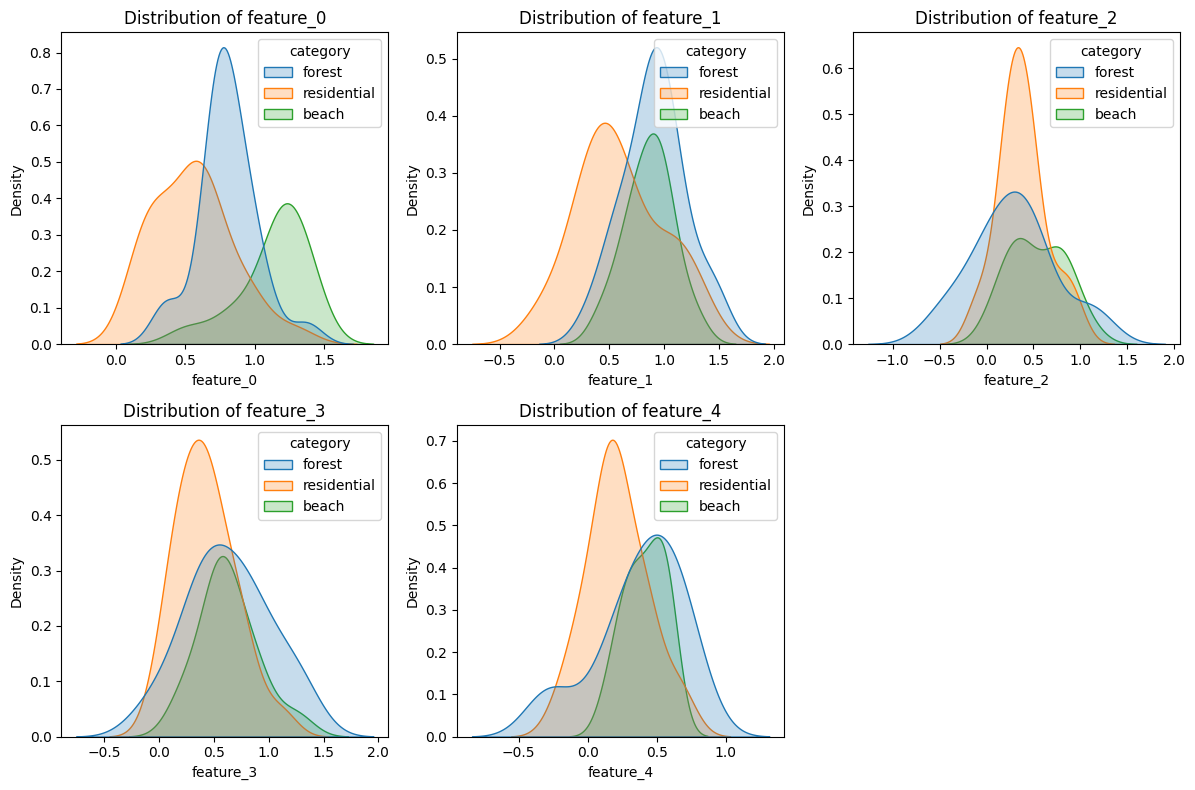

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of a few features across categories
selected_features = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']

plt.figure(figsize=(12, 8))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=features_df, x=feature, hue="category", fill=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


In [ ]:
# Create a function to calculate average within-category similarity
def calculate_average_similarity(similarity_matrix, categories):
    category_similarities = {}

    unique_categories = np.unique(categories)
    for category in unique_categories:
        # Get indices of sounds in this category
        category_indices = np.where(categories == category)[0]
        # Extract submatrix for this category
        category_similarity_matrix = similarity_matrix[np.ix_(category_indices, category_indices)]
        # Calculate the average similarity within the category
        avg_similarity = np.mean(category_similarity_matrix)
        category_similarities[category] = avg_similarity

    return category_similarities

# Calculate average within-category similarity
category_avg_similarities = calculate_average_similarity(similarity_matrix, categories)

# Display the average similarity within each category
for category, avg_sim in category_avg_similarities.items():
    print(f"Average similarity within {category}: {avg_sim:.3f}")


Average similarity within beach: 0.918
Average similarity within forest: 0.844
Average similarity within residential: 0.835


In [ ]:
!pip install ace-tools

In [ ]:
# Compute average similarity within each category and across different categories
from itertools import combinations

# Get unique categories
unique_categories = np.unique(categories)

# Dictionary to store within-category and across-category similarities
within_category_similarities = {}
across_category_similarities = []

# Calculate within-category similarities
for category in unique_categories:
    # Get indices for the current category
    indices = np.where(categories == category)[0]
    # Extract submatrix for the current category
    submatrix = similarity_matrix[np.ix_(indices, indices)]
    # Calculate average similarity within the category (excluding diagonal elements)
    within_similarity = (np.sum(submatrix) - len(indices)) / (len(indices) * (len(indices) - 1))
    within_category_similarities[category] = within_similarity

# Calculate across-category similarities
for cat1, cat2 in combinations(unique_categories, 2):
    # Get indices for each category
    indices_1 = np.where(categories == cat1)[0]
    indices_2 = np.where(categories == cat2)[0]
    # Extract submatrix for across-category similarities
    submatrix = similarity_matrix[np.ix_(indices_1, indices_2)]
    # Calculate average similarity across categories
    across_similarity = np.mean(submatrix)
    across_category_similarities.append((cat1, cat2, across_similarity))

# Display results
print("Average Within-Category Similarities:")
for category, avg_similarity in within_category_similarities.items():
    print(f"{category}: {avg_similarity:.3f}")

print("\nAverage Across-Category Similarities:")
for cat1, cat2, avg_similarity in across_category_similarities:
    print(f"{cat1} - {cat2}: {avg_similarity:.3f}")


Average Within-Category Similarities:
beach: 0.912
forest: 0.837
residential: 0.829

Average Across-Category Similarities:
beach - forest: 0.797
beach - residential: 0.768
forest - residential: 0.778


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Extract the feature columns (ignore filename and category)
feature_columns = [col for col in features_df.columns if col.startswith('feature_')]
X = features_df[feature_columns]
categories = features_df['category'].values

# Apply PCA to reduce dimensions and focus on principal components
pca = PCA(n_components=3)  # Reduce to 20 components for better separation
X_pca = pca.fit_transform(X)

# Compute cosine similarity on the PCA-transformed features
similarity_matrix_pca = cosine_similarity(X_pca)

# Calculate within-category and across-category similarities based on PCA features
within_category_similarities_pca = {}
across_category_similarities_pca = []

# Calculate within-category similarities
for category in np.unique(categories):
    indices = np.where(categories == category)[0]
    submatrix = similarity_matrix_pca[np.ix_(indices, indices)]
    within_similarity = (np.sum(submatrix) - len(indices)) / (len(indices) * (len(indices) - 1))
    within_category_similarities_pca[category] = within_similarity

# Calculate across-category similarities
for cat1, cat2 in combinations(np.unique(categories), 2):
    indices_1 = np.where(categories == cat1)[0]
    indices_2 = np.where(categories == cat2)[0]
    submatrix = similarity_matrix_pca[np.ix_(indices_1, indices_2)]
    across_similarity = np.mean(submatrix)
    across_category_similarities_pca.append((cat1, cat2, across_similarity))

# Display results after PCA
print("Average Within-Category Similarities (PCA):")
for category, avg_similarity in within_category_similarities_pca.items():
    print(f"{category}: {avg_similarity:.3f}")

print("\nAverage Across-Category Similarities (PCA):")
for cat1, cat2, avg_similarity in across_category_similarities_pca:
    print(f"{cat1} - {cat2}: {avg_similarity:.3f}")


Average Within-Category Similarities (PCA):
beach: 0.807
forest: 0.328
residential: 0.422

Average Across-Category Similarities (PCA):
beach - forest: -0.213
beach - residential: -0.328
forest - residential: -0.215


#MFCC

In [ ]:
# Define a function to extract MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, duration=10)  # Limit to 10 seconds
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.flatten()  # Flatten the MFCCs to a 1D array

# Prepare a list to store the features and file info
all_features = []

# Loop through each category and extract MFCC features
for i, row in df.iterrows():
    # For forest
    if pd.notna(row['forest']):  # Check if the value is not NaN
        forest_file = os.path.join(forest_folder, row['forest'])
        if os.path.exists(forest_file):  # Check if the file exists
            mfcc_forest = extract_mfcc(forest_file)
            all_features.append([row['forest'], 'forest'] + list(mfcc_forest))

    # For residential
    if pd.notna(row['residential']):  # Check if the value is not NaN
        residential_file = os.path.join(residential_folder, row['residential'])
        if os.path.exists(residential_file):  # Check if the file exists
            mfcc_residential = extract_mfcc(residential_file)
            all_features.append([row['residential'], 'residential'] + list(mfcc_residential))

    # For beach
    if pd.notna(row['beach']):  # Check if the value is not NaN
        beach_file = os.path.join(beach_folder, row['beach'])
        if os.path.exists(beach_file):  # Check if the file exists
            mfcc_beach = extract_mfcc(beach_file)
            all_features.append([row['beach'], 'beach'] + list(mfcc_beach))

# Create a DataFrame for the features
if all_features:
    columns = ['filename', 'category'] + [f'mfcc_{i}' for i in range(len(all_features[0]) - 2)]
    mfcc_df = pd.DataFrame(all_features, columns=columns)

    # Save the DataFrame to a CSV file in Google Drive
    output_path = '/content/drive/MyDrive/ADVANCE/mfcc_features.csv'
    mfcc_df.to_csv(output_path, index=False)

    print(f'MFCC features saved to {output_path}')
else:
    print("No valid files found or processed.")


MFCC features saved to /content/drive/MyDrive/ADVANCE/mfcc_features.csv


In [ ]:
# Let's load and display the contents of the uploaded mfcc_features.csv file
mfcc_file_path = '/content/drive/MyDrive/ADVANCE/mfcc_features.csv'

# Load the CSV file into a DataFrame
mfcc_features_df = pd.read_csv(mfcc_file_path)

# Display the first few rows of the dataframe
mfcc_features_df.head()


,filename,category,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_5593,mfcc_5594,mfcc_5595,mfcc_5596,mfcc_5597,mfcc_5598,mfcc_5599,mfcc_5600,mfcc_5601,mfcc_5602
0,00030.wav,forest,-469.749270,-439.843720,-432.97177,-438.048250,-441.026820,-443.77246,-446.62778,-440.03156,...,-0.262409,5.437753,6.563422,2.426125,6.580567,2.458714,2.763572,4.512672,4.127339,9.181509
1,00699.wav,residential,-326.176600,-303.772980,-302.52350,-305.755200,-303.247400,-291.77692,-284.15222,-283.27722,...,2.063309,4.126457,2.235530,5.420748,6.960833,2.045499,2.540700,1.758832,2.416829,6.152225
2,00095.wav,beach,-230.299030,-193.195820,-188.93872,-193.462590,-195.803560,-192.02510,-191.71355,-191.46077,...,-11.657993,-7.778958,-5.585646,-7.545844,-7.970430,-9.455165,-10.452835,-13.180140,-11.973337,-9.150803
3,00094.wav,forest,-74.109795,-38.530254,-32.42647,-23.006323,-18.999578,-17.53226,-30.47444,-36.71431,...,-8.598339,-14.995917,-8.150688,-4.412714,-2.897587,-7.212135,-11.258647,-5.637616,0.396973,-6.411211
4,01490.wav,residential,-258.897160,-228.030870,-228.96350,-232.550800,-234.312410,-234.85992,-238.11165,-238.12723,...,-14.900855,-14.788670,-13.870488,-8.832872,-10.178211,-8.045714,-8.665112,-10.495195,-12.462548,-14.991523


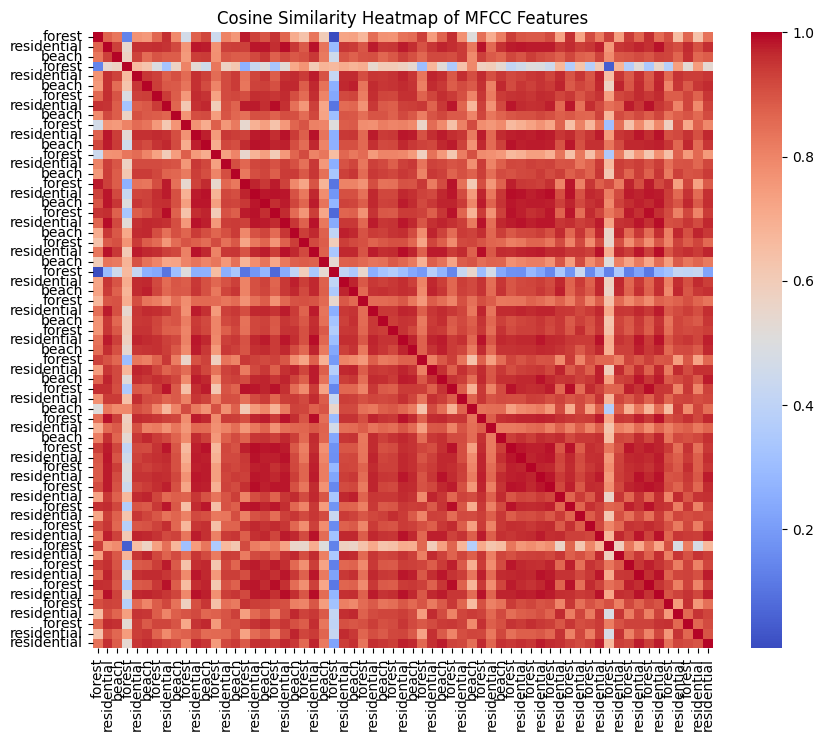

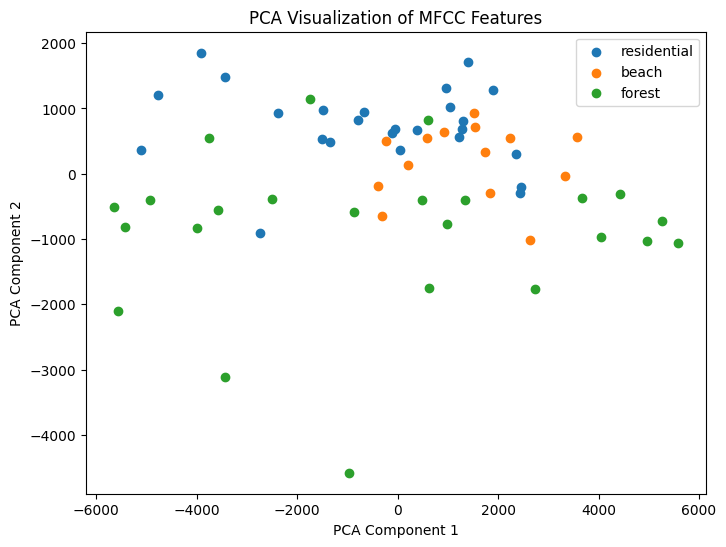

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract MFCC features and category labels from the dataframe
mfcc_features = mfcc_features_df.drop(columns=['filename', 'category']).values
categories = mfcc_features_df['category'].values

# Compute cosine similarity between all MFCC feature vectors
similarity_matrix = cosine_similarity(mfcc_features)

# Create a heatmap to visualize the similarity between sound files
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=categories, yticklabels=categories, cmap='coolwarm')
plt.title('Cosine Similarity Heatmap of MFCC Features')
plt.show()

# Use PCA for dimensionality reduction to 3 components for visualization
pca = PCA(n_components=2)
mfcc_reduced = pca.fit_transform(mfcc_features)

# Create a scatter plot to visualize the MFCC features in 2D space
plt.figure(figsize=(8, 6))
for category in set(categories):
    idx = categories == category
    plt.scatter(mfcc_reduced[idx, 0], mfcc_reduced[idx, 1], label=category)

plt.title('PCA Visualization of MFCC Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


# WAV2VEC

In [ ]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import os
import pandas as pd

In [ ]:
# Define a function to extract wav2vec features
def extract_wav2vec_features(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    # Resample if the sample rate is not 16000 Hz
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    # Process the waveform with the wav2vec processor
    inputs = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the last hidden states as features
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Prepare a list to store the features and file info
all_features = []

# Load the pre-trained Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h") # Load the processor
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h") # Load the model

# Loop through each category and extract wav2vec features
for i, row in df.iterrows():
    # For forest
    if pd.notna(row['forest']):
        forest_file = os.path.join(forest_folder, row['forest'])
        if os.path.exists(forest_file):
            wav2vec_forest = extract_wav2vec_features(forest_file)
            all_features.append([row['forest'], 'forest'] + list(wav2vec_forest))

    # For residential
    if pd.notna(row['residential']):
        residential_file = os.path.join(residential_folder, row['residential'])
        if os.path.exists(residential_file):
            wav2vec_residential = extract_wav2vec_features(residential_file)
            all_features.append([row['residential'], 'residential'] + list(wav2vec_residential))

    # For beach
    if pd.notna(row['beach']):
        beach_file = os.path.join(beach_folder, row['beach'])
        if os.path.exists(beach_file):
            wav2vec_beach = extract_wav2vec_features(beach_file)
            all_features.append([row['beach'], 'beach'] + list(wav2vec_beach))

# Create a DataFrame for the features
columns = ['filename', 'category'] + [f'wav2vec_{i}' for i in range(len(all_features[0]) - 2)]
wav2vec_df = pd.DataFrame(all_features, columns=columns)

# Save the DataFrame to a CSV file in Google Drive
output_path = '/content/drive/MyDrive/ADVANCE/wav2vec_features.csv'
wav2vec_df.to_csv(output_path, index=False)

print(f'wav2vec features saved to {output_path}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wav2vec features saved to /content/drive/MyDrive/ADVANCE/wav2vec_features.csv


In [ ]:
# Re-importing the necessary library
import pandas as pd

# Load the CSV file into a DataFrame
wav2vec_file_path = '/content/drive/MyDrive/ADVANCE/wav2vec_features.csv'
wav2vec_features_df = pd.read_csv(wav2vec_file_path)

# Display the first few rows of the dataframe
wav2vec_features_df.head()

,filename,category,wav2vec_0,wav2vec_1,wav2vec_2,wav2vec_3,wav2vec_4,wav2vec_5,wav2vec_6,wav2vec_7,...,wav2vec_758,wav2vec_759,wav2vec_760,wav2vec_761,wav2vec_762,wav2vec_763,wav2vec_764,wav2vec_765,wav2vec_766,wav2vec_767
0,00030.wav,forest,-0.114898,0.082470,0.005783,-0.001171,-0.183466,-0.112653,0.086995,-0.039636,...,0.148265,-0.057195,0.030951,0.006412,-0.032014,-0.011766,-0.024070,-0.147281,-0.015927,-0.087607
1,00699.wav,residential,-0.096085,0.014334,-0.045293,-0.035013,-0.017942,-0.114835,0.009109,-0.008716,...,0.106572,-0.050331,-0.114742,0.067684,0.131129,0.002044,-0.020215,-0.099447,0.013243,0.034298
2,00095.wav,beach,-0.126236,0.024806,0.037943,0.013374,-0.129983,-0.149701,-0.005833,-0.001836,...,0.107603,-0.053382,0.111794,0.269336,0.170617,0.010094,-0.021493,0.017354,0.009711,-0.101306
3,00094.wav,forest,-0.137282,0.073458,-0.008388,-0.048140,-0.129857,-0.144101,0.013327,-0.012527,...,0.215436,-0.060846,-0.014028,0.221085,-0.091157,-0.014529,-0.024412,-0.172805,-0.001179,-0.019721
4,01490.wav,residential,-0.008440,0.002851,-0.075469,-0.062454,0.021317,-0.121480,0.133156,-0.002216,...,0.025843,-0.048665,-0.077867,0.059310,-0.007167,0.001487,-0.016538,0.069121,-0.029208,0.067968


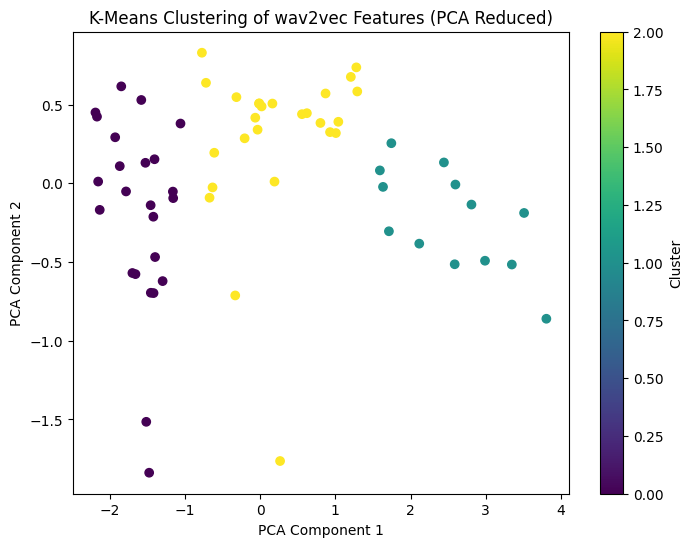

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract the wav2vec features (excluding filename and category)
wav2vec_features = wav2vec_features_df.drop(columns=['filename', 'category']).values

# Reduce dimensionality using PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2)
wav2vec_pca = pca.fit_transform(wav2vec_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(wav2vec_features)

# Add cluster labels to the DataFrame
wav2vec_features_df['cluster'] = clusters

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(wav2vec_pca[:, 0], wav2vec_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering of wav2vec Features (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


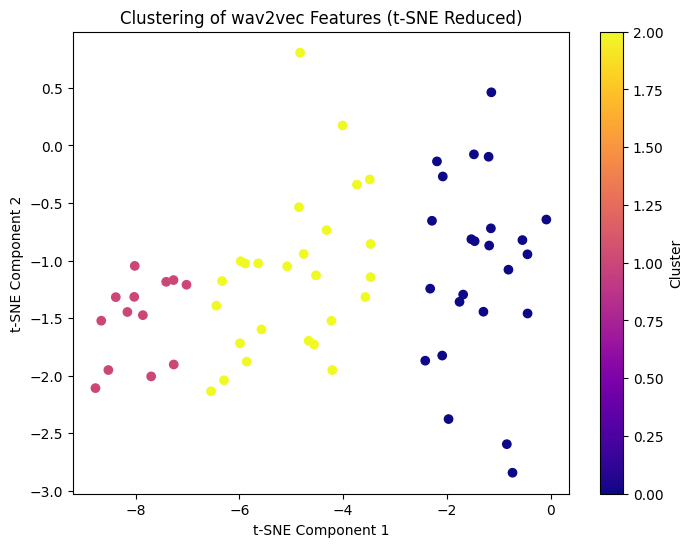

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction to 2 components
tsne = TSNE(n_components=2, random_state=42)
wav2vec_tsne = tsne.fit_transform(wav2vec_features)

# Plot the clusters in 2D space (t-SNE reduced)
plt.figure(figsize=(8, 6))
plt.scatter(wav2vec_tsne[:, 0], wav2vec_tsne[:, 1], c=clusters, cmap='plasma') # Use 'clusters' instead of 'dbscan_clusters'
plt.title('Clustering of wav2vec Features (t-SNE Reduced)') # Changed title to be more general
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

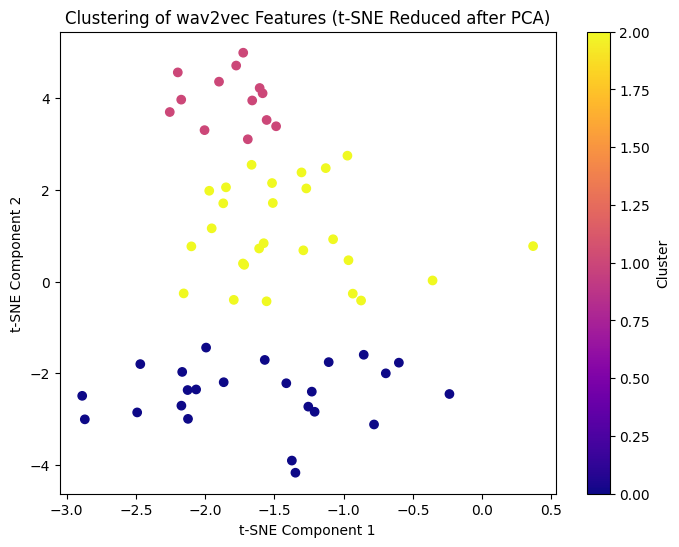

In [ ]:
# First, reduce dimensionality with PCA to speed up t-SNE (e.g., reduce to 50 components)
pca = PCA(n_components=50)
wav2vec_reduced_pca = pca.fit_transform(wav2vec_features)

# Now, apply t-SNE to the reduced data
tsne = TSNE(n_components=2, random_state=42)
wav2vec_tsne_reduced = tsne.fit_transform(wav2vec_reduced_pca)

# Plot the clusters in 2D space (t-SNE reduced)
plt.figure(figsize=(8, 6))
plt.scatter(wav2vec_tsne_reduced[:, 0], wav2vec_tsne_reduced[:, 1], c=clusters, cmap='plasma') # Use 'clusters' which is defined
plt.title('Clustering of wav2vec Features (t-SNE Reduced after PCA)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

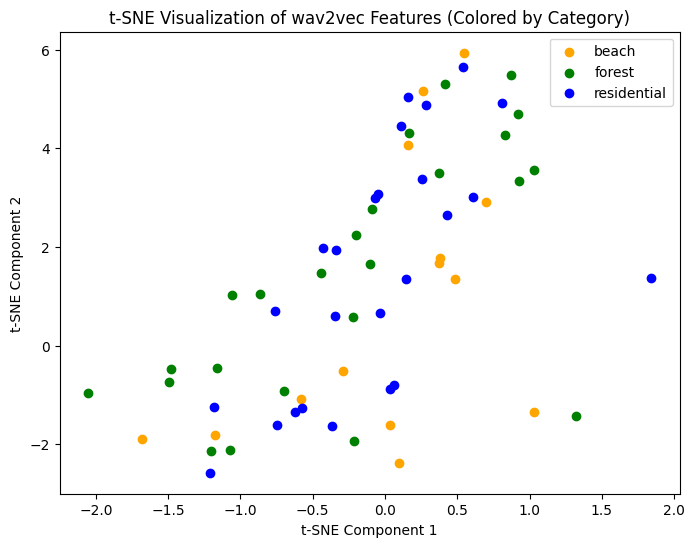

In [ ]:
# Recompute the t-SNE after applying PCA to reduce dimensions
pca = PCA(n_components=50)
wav2vec_reduced_pca = pca.fit_transform(wav2vec_features)

# Now, apply t-SNE to the reduced data
tsne = TSNE(n_components=2, random_state=42)
wav2vec_tsne_reduced = tsne.fit_transform(wav2vec_reduced_pca)

# Plot the t-SNE components, colored by actual categories
plt.figure(figsize=(8, 6))
category_colors = {'forest': 'green', 'residential': 'blue', 'beach': 'orange'}

# Extract categories from the DataFrame
categories = wav2vec_features_df['category']

for category in set(categories):
    idx = categories == category
    plt.scatter(wav2vec_tsne_reduced[idx, 0], wav2vec_tsne_reduced[idx, 1], label=category, color=category_colors[category])

plt.title('t-SNE Visualization of wav2vec Features (Colored by Category)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()